In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

# Process functions

In [50]:
def processMarkovLen(init):
    temp = []
    zeros = 0
    for i, v in enumerate(init):
        if(v == 0):
            zeros = zeros+1
            v = 2
        if(i>1):
            if(v==1):
                temp.append(init[i-1])
    temp.append(v)
    
    final = list(np.ones(int(temp[0]+1+zeros))*temp[0])
    for i in range(len(temp)-1):
        final += list(np.linspace(int(temp[i]), int(temp[i+1]), int(temp[i+1]+1)))[1:]
    return np.asarray(final)

In [54]:
def processDataDSA(pathTXT):
    acceptance_pb = []
    acc_best_sol = []
    temp = []
    density = []
    markov_len = []
    best_y = []
    curr_y = []
    runtime = 0
    iteration_nbr = 0
    
    with open(pathTXT, "r") as file:
        dimension = file.readline().count('BEST x')
        best_xs = np.zeros((dimension, 0))
        curr_xs = np.zeros((dimension, 0))

        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                final = 7
                a = line.split("|")
                a = [i.strip() for i in a][:-1]
                if(float(a[5])!=0):
                    acceptance_pb.append(float(a[0]))
                    acc_best_sol.append(a[1])
                    temp.append(float(a[2]))
                    density.append(float(a[3]))
                    markov_len.append(float(a[4]))
                    best_y.append(float(a[5]))
                    if(float(a[6])>10e6):
                        curr_y.append(60.0)
                    else: 
                        curr_y.append(float(a[6]))

                    best_xs_temp = np.zeros((dimension, 1))
                    curr_xs_temp = np.zeros((dimension, 1))
                    for i in range(dimension):
                        index = i*2
                        best_xs_temp[i] = float(a[final+index+1])
                        curr_xs_temp[i] = float(a[final+index])
                    best_xs = np.concatenate((best_xs, best_xs_temp), axis = 1)
                    curr_xs = np.concatenate((curr_xs, curr_xs_temp), axis = 1)
                
    acceptance_pb = np.asarray(acceptance_pb)
    acc_best_sol = np.asarray(acc_best_sol)
    temp = np.asarray(temp)
    best_y = np.asarray(best_y)
    curr_y = np.asarray(curr_y)
    
    density = np.asarray(density)
    markov_len = processMarkovLen(markov_len)[:len(temp)]
    
    
    return acceptance_pb, acc_best_sol, temp, density, markov_len, best_y, curr_y, best_xs, curr_xs, runtime, iteration_nbr

In [59]:
def drawPlotDSA(plotAll, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor, density_factor):
    set_matplotlib_formats('retina')

    x = np.arange(len(best_y))
    string = str(prob_factor)
    string2 = str(density_factor)
        
    line1, = plt.plot(x, best_y, color='g')
    if(plotAll):
        line2, = plt.plot(x, temp, color='orange')
        line3, = plt.plot(x, markov_len, color='grey')
        line5, = plt.plot(x, density*density_factor, color='purple')
        plt.scatter(x, acceptance_pb*prob_factor, s=1, marker='+', label='Acceptance proba x'+string, color='pink')
        line2.set_label('Temperature')
        line3.set_label('Actual MarkovChains Length')
        line5.set_label('CG Density x'+string2)
        
    plt.scatter(x, curr_y, s=3, marker=">", label='Current Solution', color='blue')


    line1.set_label('Best Solution')

    fig = plt.gcf()
    fig.set_size_inches(13,10)

    plt.legend()
    plt.yscale('log')
    plt.show()

# Plotting behavior of improvement to understand parameters

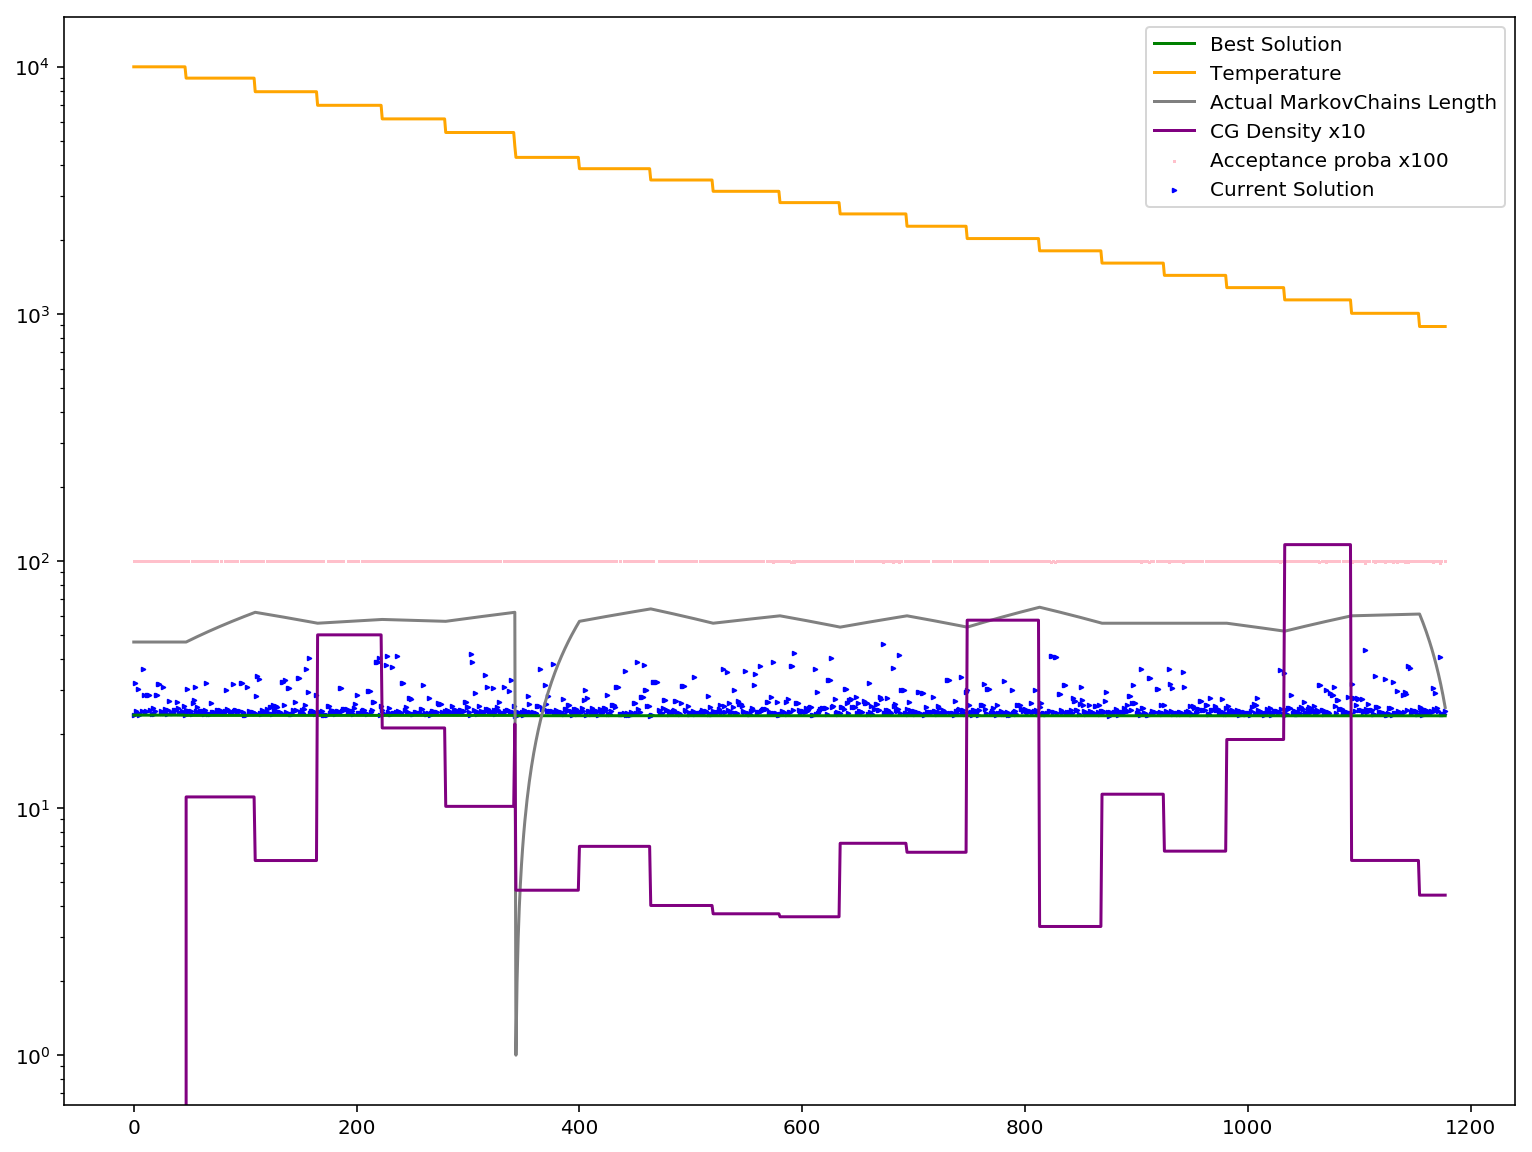

In [102]:
path = "../simulations/ZF0ZAUTcE_DSA_results.txt"
acceptance_pb, acc_best_sol, temp, density, markov_len, best_y, curr_y, best_xs, curr_xs, runtime, iteration_nbr = processDataDSA(path)

drawPlotDSA(True, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor=100, density_factor=10)


# Plot the function 

All current solution greater than 30 are now equal to 30, we want to eliminate them !

In [163]:
import pandas as pd

def processData(pathTXT):
    a = []
    tab = []
    i = 0
    with open(pathTXT, "r") as file:
        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                a = line.split("|")[5:]
                a = [i.strip() for i in a][:-1]
                if(i!=0):
                    a = [float(i) for i in a]
                tab.append(a)
            i+=1
            
    titles = tab[0] 
    #print(titles)
    dtf = pd.DataFrame(data=tab[1:],columns=titles)
    
    isNotInit = dtf['BEST y']!=0.0
    dtf_all = dtf[isNotInit]
    
    aa = np.array(dtf_all['CURR y'].values.tolist())
    dtf_all['CURR y'] = [v if v < 30 else 30 for v in aa]


    col_to_del = [titles[0]]+titles[3::2]
    afterdrop_cur = dtf_all.drop(col_to_del, axis = 1)
    col_to_del = [titles[1]]+titles[2::2]
    afterdrop_bes = dtf_all.drop(col_to_del, axis = 1)
    
    
    return dtf_all, afterdrop_cur, afterdrop_bes

In [206]:
data, data_cur, data_best = processData('../simulations/OwnLejjl0_DSA_results.txt')
data

/Users/leobouraux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,BEST y,CURR y,CURR x,BEST x,CURR x2,BEST x2,CURR x3,BEST x3,CURR x4,BEST x4
35,23.947455,30.000000,4.525627,4.003029,0.342209,-0.435343,-0.975437,-0.135012,2.059879,3.164234
36,23.947455,24.534870,4.760857,4.003029,-0.294704,-0.435343,-1.421620,-0.135012,3.169265,3.164234
37,23.947455,24.993427,4.124453,4.003029,-0.888305,-0.435343,-1.893668,-0.135012,4.421861,3.164234
38,23.947455,25.272534,4.529404,4.003029,0.728384,-0.435343,-1.131322,-0.135012,4.390169,3.164234
39,23.947455,30.000000,4.309831,4.003029,-0.954555,-0.435343,-1.772384,-0.135012,1.478053,3.164234
40,23.947455,24.767049,4.761987,4.003029,1.871923,-0.435343,-0.702718,-0.135012,4.035517,3.164234
41,23.947455,25.846903,4.046191,4.003029,-0.167014,-0.435343,-1.460707,-0.135012,4.941638,3.164234
42,23.947455,24.474662,2.776869,4.003029,0.252214,-0.435343,-1.754602,-0.135012,3.994888,3.164234
43,23.947455,24.239877,5.316277,4.003029,-0.447015,-0.435343,-0.794363,-0.135012,4.210486,3.164234
44,23.947455,24.064497,3.398282,4.003029,1.497768,-0.435343,-2.459319,-0.135012,3.685805,3.164234


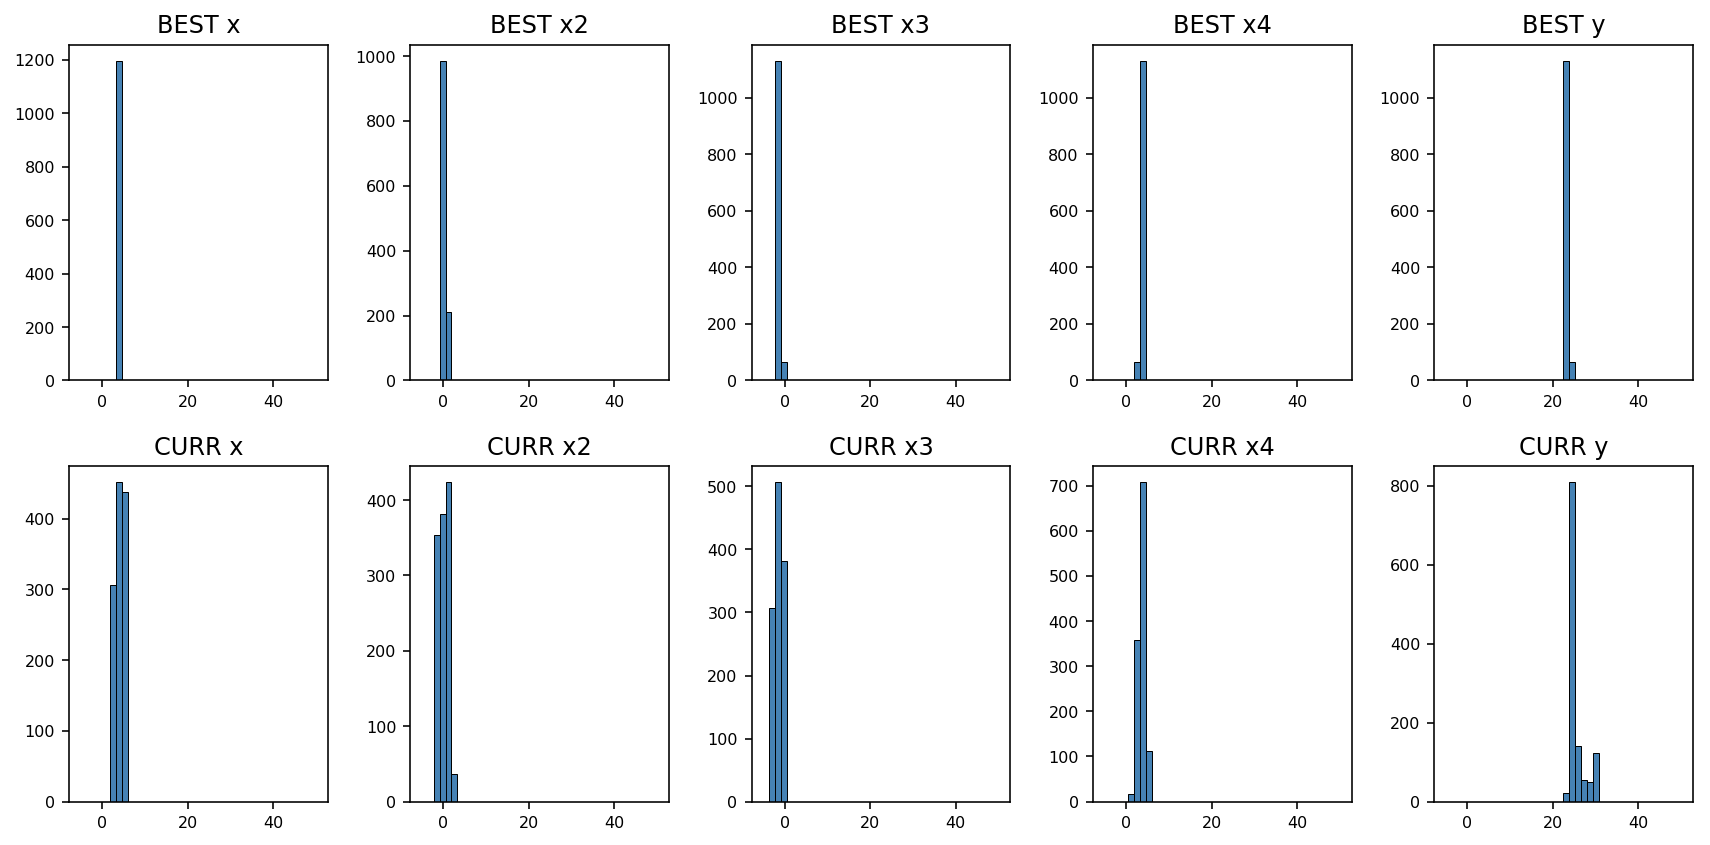

In [207]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

data.hist(bins=40, color='steelblue', edgecolor='black', linewidth=0.5,
              xlabelsize=8, ylabelsize=8, grid=False, layout=(2,5), range=[-5,50])


plt.tight_layout(rect=(0, 0.5, 2, 2))   
plt.savefig('foo.png', format='png', dpi=400)


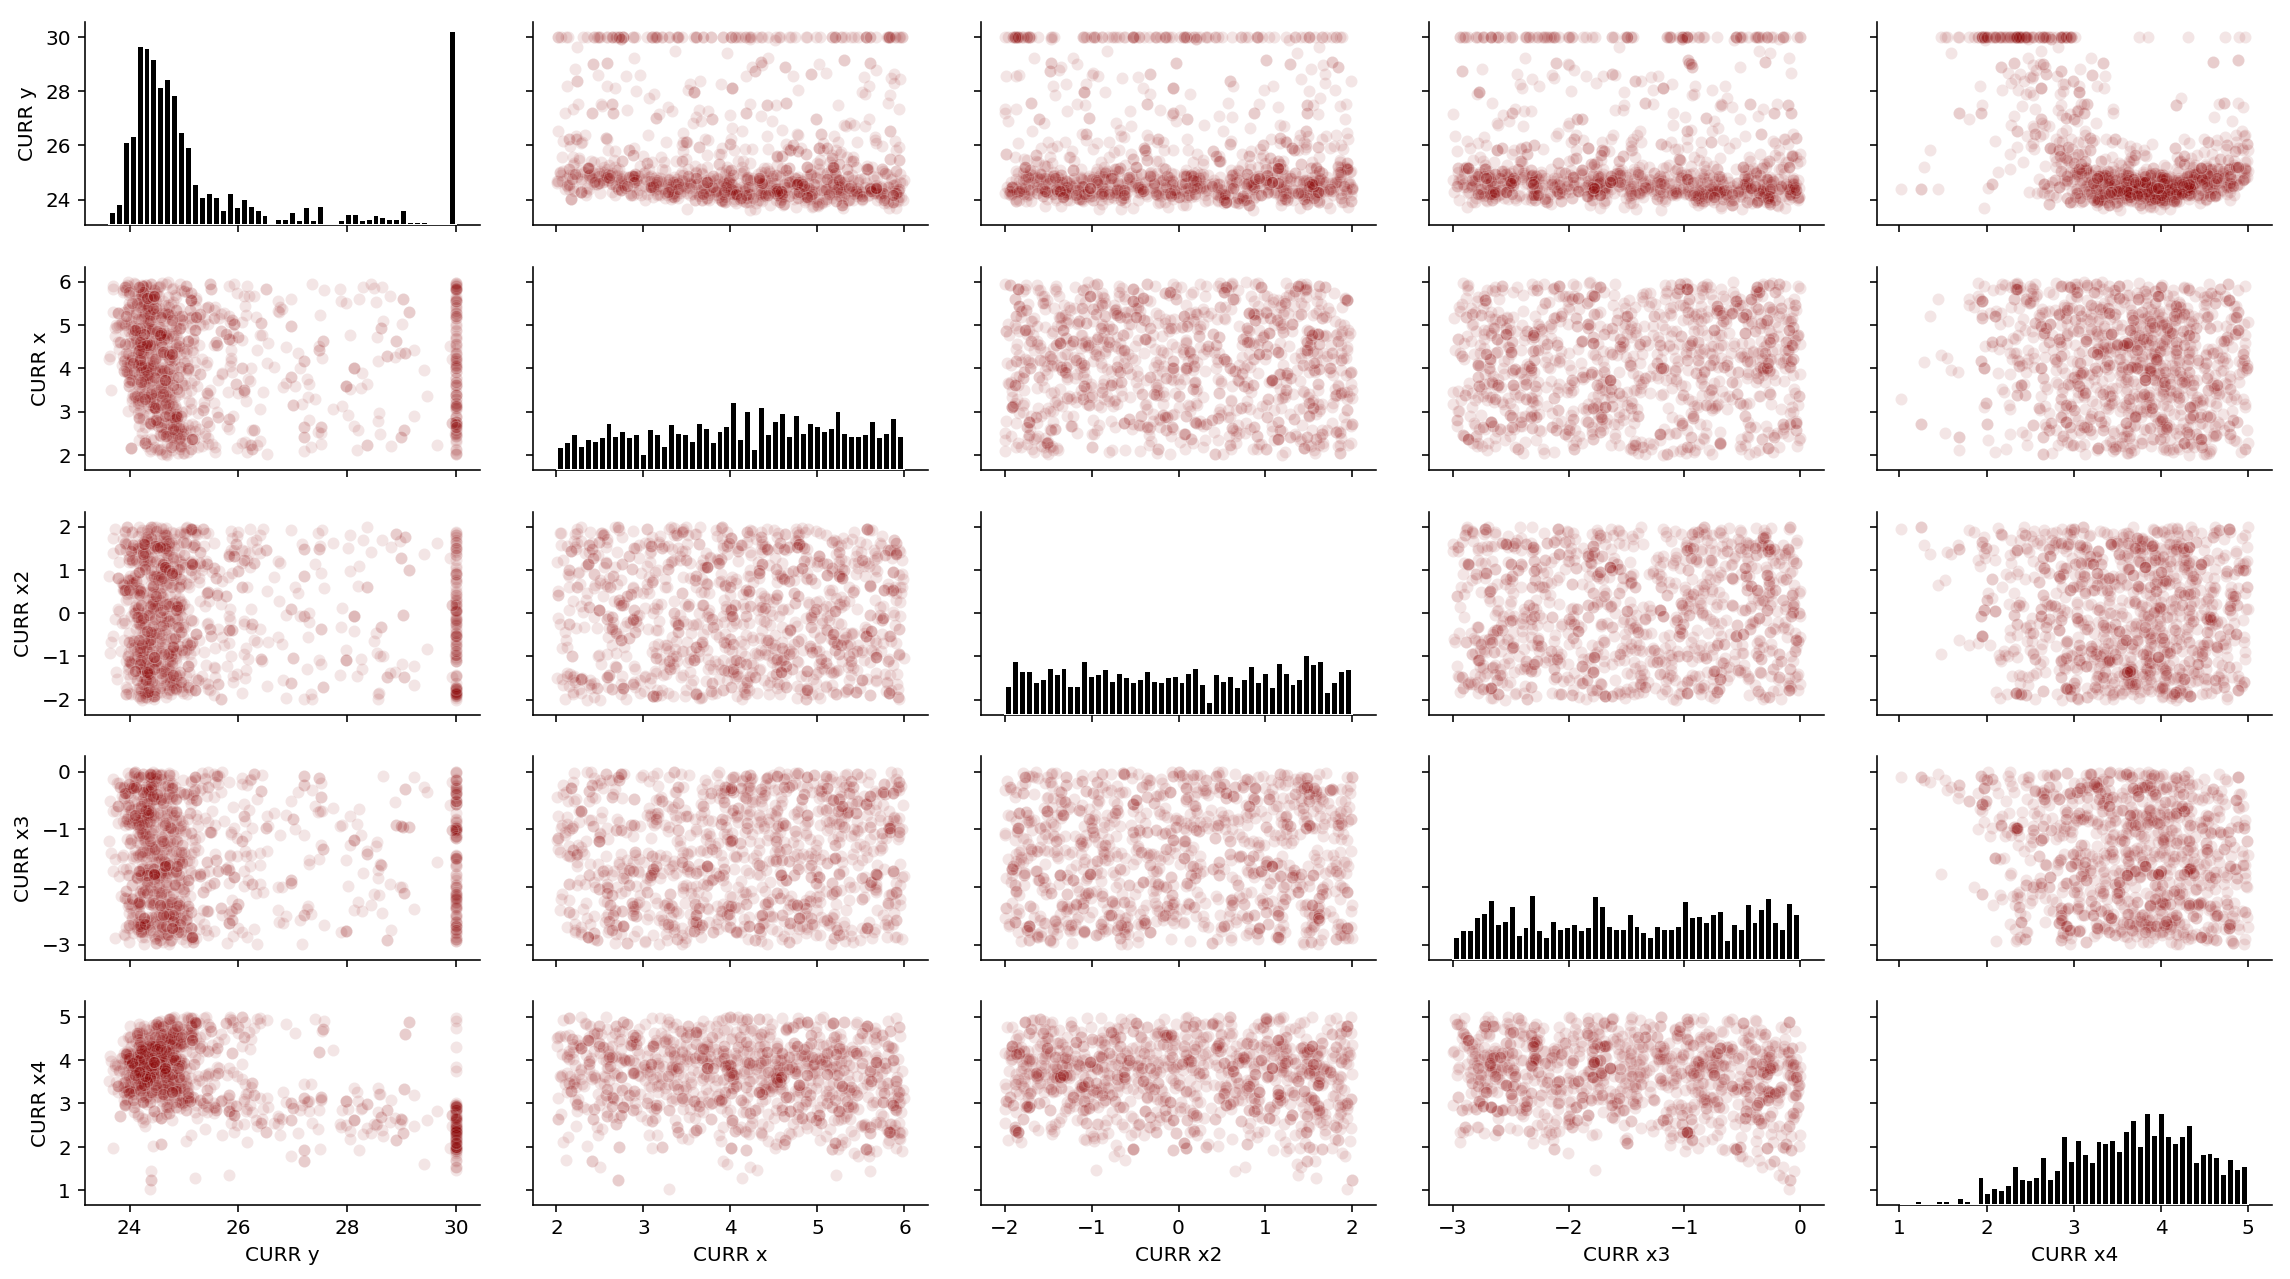

In [208]:
pp = sns.pairplot(data_cur, height=1.8, aspect=1.8,
                  plot_kws={'edgecolor':"k", 'linewidth':0.5, 'alpha':0.1, 'edgecolor': 'w', 'color':'darkred'},
                  diag_kind="hist", diag_kws={'bins':50, 'color':'black', 'edgecolor': 'w'})

A chaque fois il y a des CURRy qui sont = à l'infini au début des runs

# Parallel coordinates

In [209]:
import matplotlib.colors as colors

def truncate_colormap(cmap_str, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_str)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#arr = np.linspace(0, 50, 100).reshape((10, 10))
#fig, ax = plt.subplots(ncols=2)

#cmap_str = 'Greys'
#new_cmap = truncate_colormap(cmap, 0.1, 1)
#ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
#ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
#plt.show()

In [242]:
# redefinition of parallel_coordinates function in order to plot the color bar

def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    from collections import OrderedDict

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)
    
    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure(figsize=(20,10))
    ax = plt.gca()

    colormap = truncate_colormap(colormap, 0, 0.8)
    Colorm = plt.get_cmap(colormap)
    
    #Change the bests 10% solutions in pink
    ###
    greysR = cm.get_cmap(colormap, 256)
    newcolors = greysR(np.linspace(0, 1, 256))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[:10, :] = pink
    Colorm = ListedColormap(newcolors)
    ###

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        ymin=-3
        ymax=6.1
        ax.set_ylim([ymin,ymax])
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), alpha=0.4, **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc='upper right')
    ax.grid()
    #ax.set_facecolor('navajowhite')


    bounds = np.linspace(class_min,class_max,10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.5f')

    return fig

####



In [243]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
print(newcolors.shape)
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25] = pink

print(newcolors)

(256, 4)
[[0.96875  0.09375  0.578125 1.      ]
 [0.96875  0.09375  0.578125 1.      ]
 [0.96875  0.09375  0.578125 1.      ]
 ...
 [0.974417 0.90359  0.130215 1.      ]
 [0.983868 0.904867 0.136897 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


No handles with labels found to put in legend.


Text(0, 0.5, 'CURR y values')

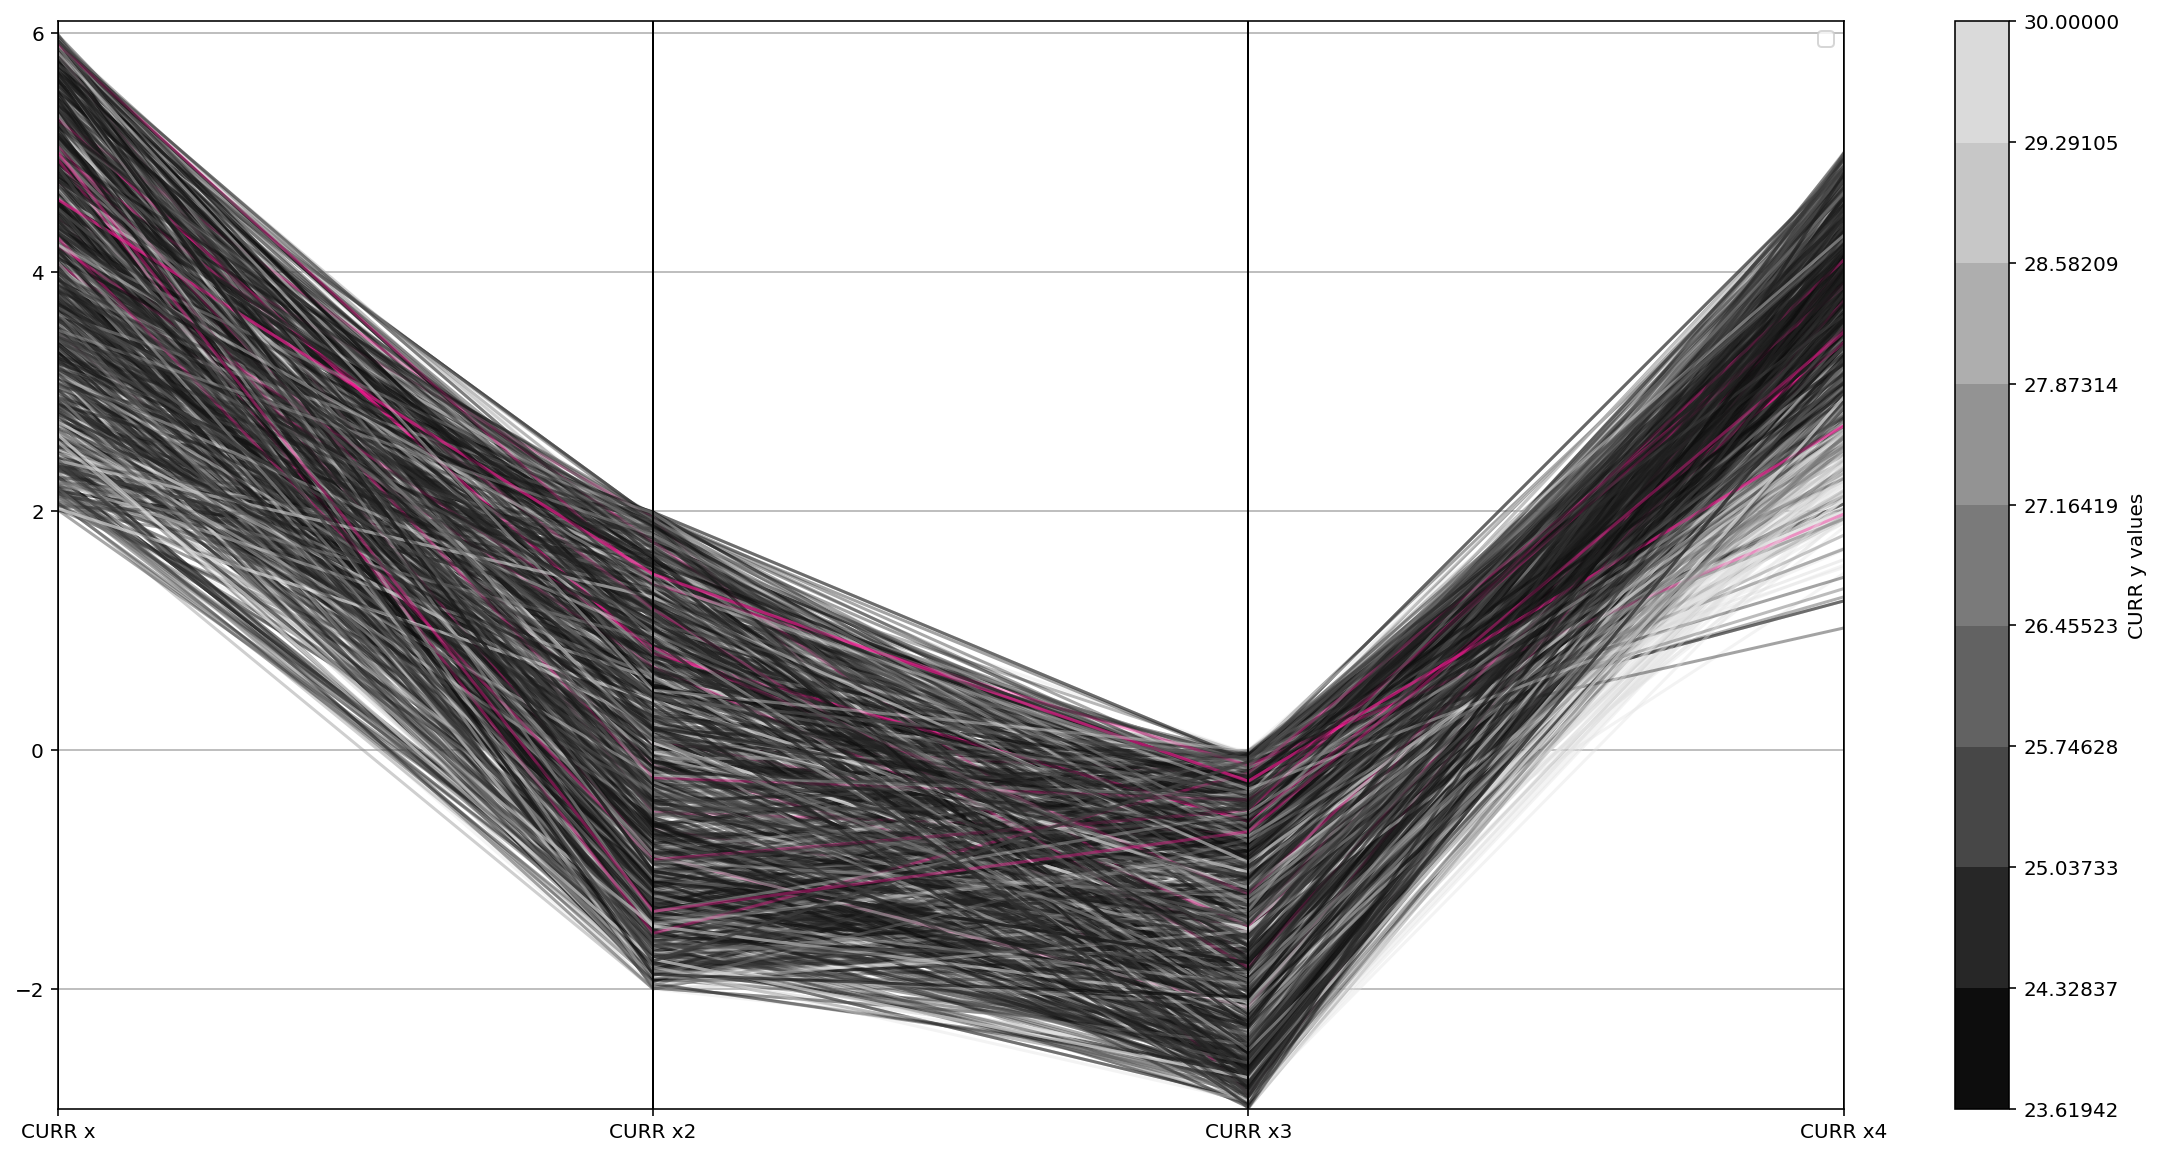

In [244]:
parallel_coordinates(data_cur, 'CURR y', colormap = 'Greys_r')
plt.ylabel("CURR y values")

# Best of 4 parrallel coordinates

In [212]:
data0, data_cur0, data_best0 = processData('../simulations/aRq0jta00_DSA_results.txt')
data1, data_cur1, data_best1 = processData('../simulations/OwnLejjl0_DSA_results.txt')
data2, data_cur2, data_best2 = processData('../simulations/UqzlklOyY_DSA_results.txt')
data3, data_cur3, data_best3 = processData('../simulations/ZF0ZAUTcE_DSA_results.txt')

isGlobalBest = data_best0['BEST y']==data_best0['BEST y'].min()
data_best0 = data_best0[isGlobalBest].head()
isGlobalBest = data_best1['BEST y']==data_best1['BEST y'].min()
data_best1 = data_best1[isGlobalBest].head()
isGlobalBest = data_best2['BEST y']==data_best2['BEST y'].min()
data_best2 = data_best2[isGlobalBest].head()
isGlobalBest = data_best3['BEST y']==data_best3['BEST y'].min()
data_best3 = data_best3[isGlobalBest].head()

data = pd.concat([data_best0,data_best1,data_best2,data_best3])

/Users/leobouraux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [213]:
data

,BEST y,BEST x,BEST x2,BEST x3,BEST x4
113,23.743445,5.417985,-1.913749,-0.935984,3.975210
114,23.743445,5.417985,-1.913749,-0.935984,3.975210
115,23.743445,5.417985,-1.913749,-0.935984,3.975210
116,23.743445,5.417985,-1.913749,-0.935984,3.975210
117,23.743445,5.417985,-1.913749,-0.935984,3.975210
1020,23.619419,4.220779,0.859727,-1.200206,3.525576
1021,23.619419,4.220779,0.859727,-1.200206,3.525576
1022,23.619419,4.220779,0.859727,-1.200206,3.525576
1023,23.619419,4.220779,0.859727,-1.200206,3.525576
1024,23.619419,4.220779,0.859727,-1.200206,3.525576


No handles with labels found to put in legend.


Text(0, 0.5, 'BEST y values')

<Figure size 432x288 with 0 Axes>

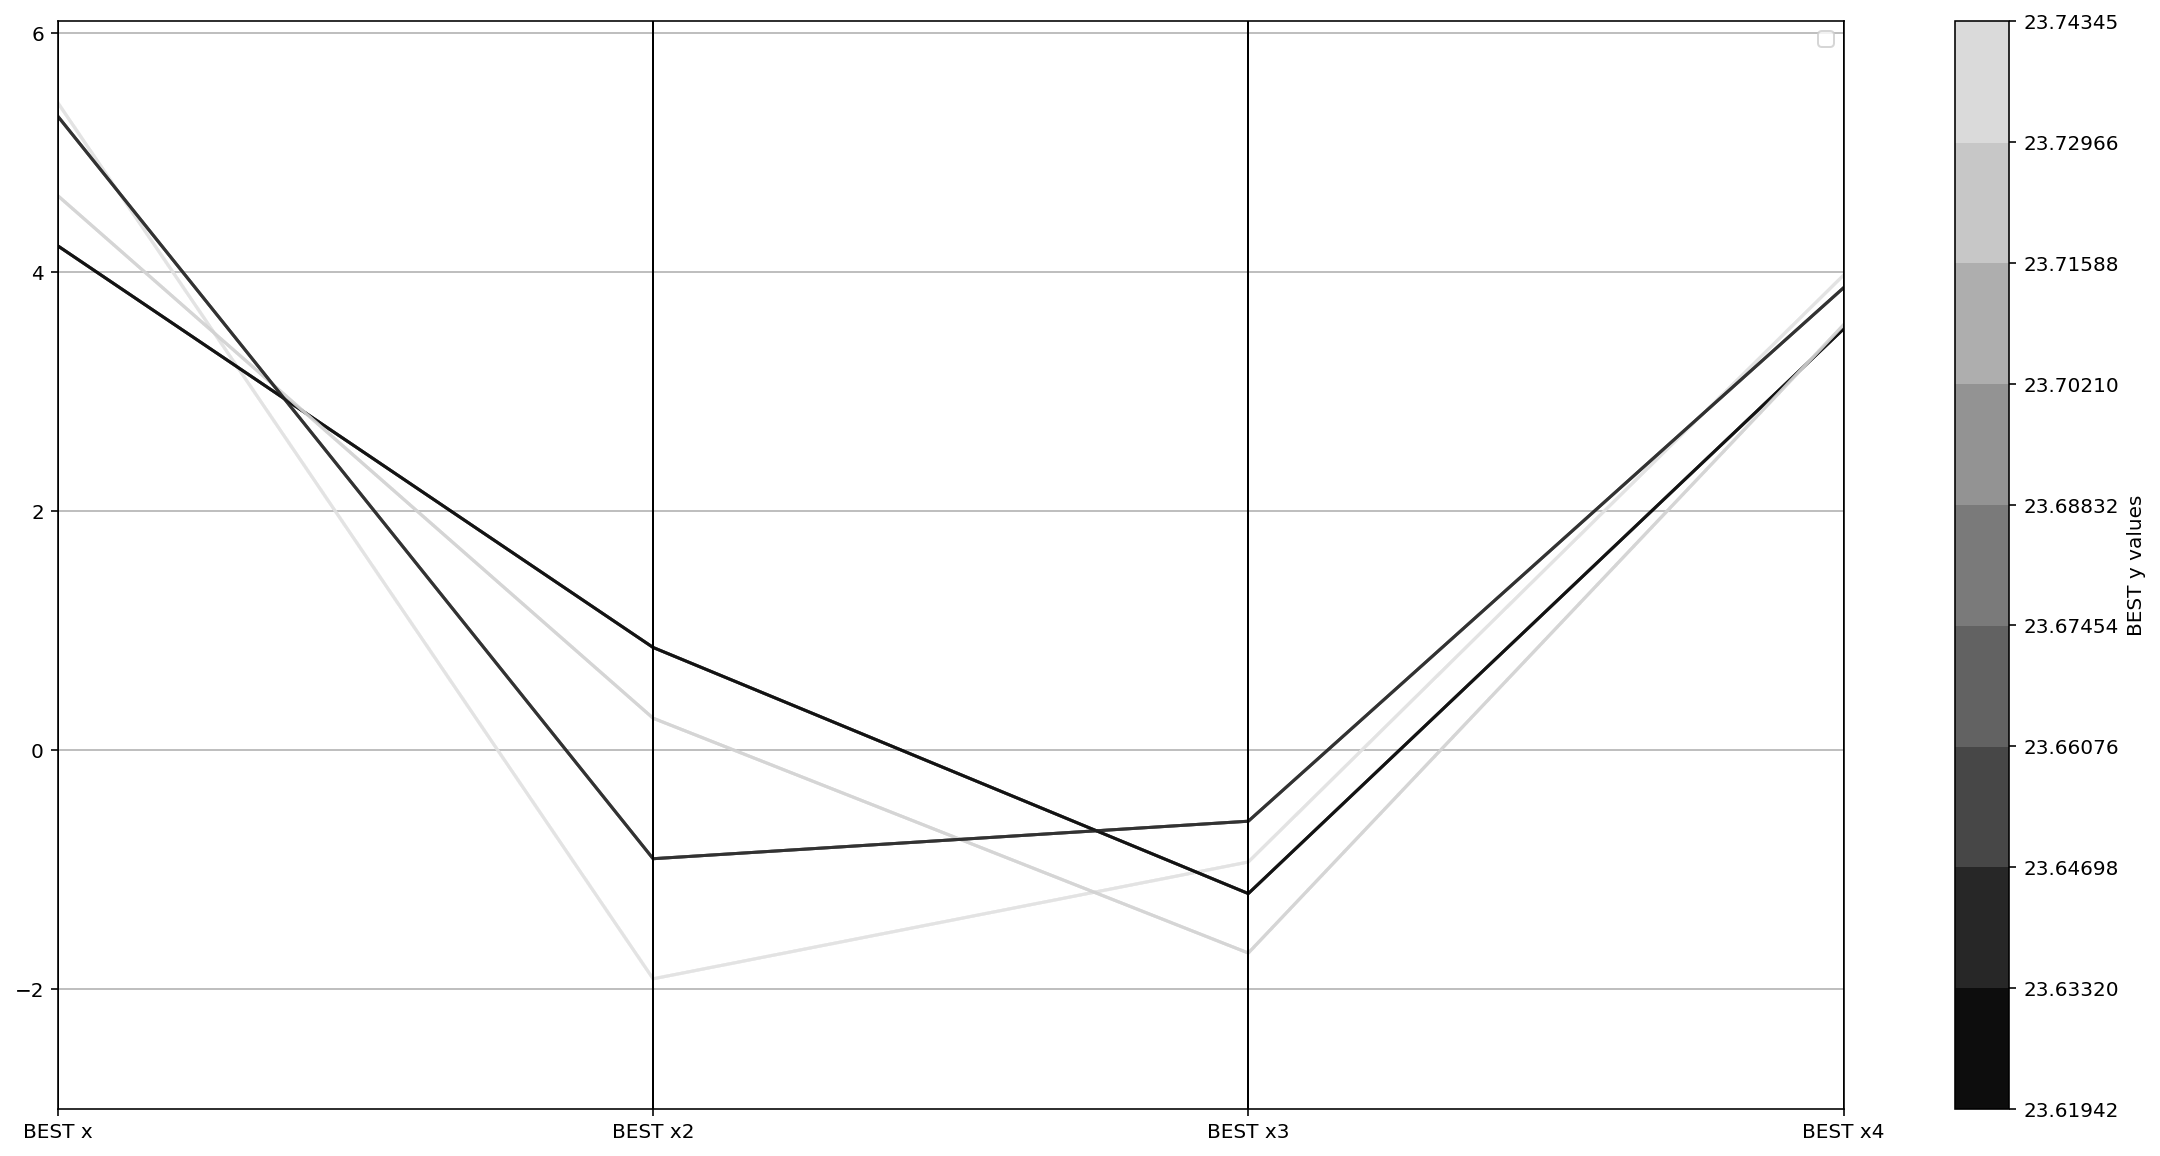

In [214]:
plt.close()
plt.gcf().clear()    

parallel_coordinates(data, 'BEST y', colormap = 'Greys_r')
plt.ylabel("BEST y values")